### Hugo Englund | 2021-01-06

# Laboration 5: Part B

## Outline
In this part of the laboration our aim is to classify if IMDB reviews are either good or bad. This will done by:
1. Create and analyze the performance of the following models:
    - SimpleRNN(32)
    - LSTM(32)
    - Larger LSTM, e.g., LSTM(128)
    - Bidirectional LSTM, i.e., BiLSTM(32)

2. Test the best model on the following text sequences and analyze the results:


```
test_sentences = [
"That movie was absolutely awful",
"The acting was a bit lacking",
"The film was creative and surprising",
"Absolutely fantastic!",
"This movie is not worth the money",
"The only positive thing with this movie is the music"
]
```



### Setup
Import relevant packages for the given task:

In [6]:
import keras
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Input, Embedding, SimpleRNN, LSTM, Bidirectional, Dense
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.regularizers import l2
from keras.datasets import imdb # IMDB data
import numpy as np

### (Performance plot function)

In [7]:
import matplotlib.pyplot as plt

# plots accuracy and loss for training and validation, respectively
def plot_performance(history):
  # plot accuracy during training and validation
  plt.plot(history.history["accuracy"], label="Training\naccuracy")
  plt.plot(history.history["val_accuracy"], label="Validation\naccuracy")
  plt.xlabel("Epoch")
  plt.ylabel("Accuracy")
  plt.ylim([0, 1])
  plt.legend(loc="best")
  plt.title("Training and validation accuracies")
  plt.grid(b=True)
  plt.show()

  # plot loss during training and validation
  plt.plot(history.history["loss"], label="Training\nloss")
  plt.plot(history.history["val_loss"], label='Validation\nloss')
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.ylim([0, 1])
  plt.legend(loc="best")
  plt.title("Training and validation losses")
  plt.grid(b=True)
  plt.show()
  return

### Import the IMDB dataset
We load the data from the keras module "imdb":

In [55]:
# define restrictions of the data
max_features = 10000  # number of words to consider as features

# load the data, and split into train and test set
(input_train, y_train), (input_test, y_test) = imdb.load_data(num_words=max_features)
print(len(input_train), 'train sequences')
print(len(input_test), 'test sequences')

<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/datasets/imdb.py:159: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])


25000 train sequences
25000 test sequences


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/datasets/imdb.py:160: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_test, y_test = np.array(xs[idx:]), np.array(labels[idx:])


### Analyze the data structure
We create a reversed index to display a review to get a hint of what we are dealing with.

#### Display an example review:



In [57]:
# obtain vocabulary for the IMDB data
test_vocab = imdb.get_word_index()

# create a reversed dictionary such that {index: word, ...}
rev_idx = {v+3:k for k, v in test_vocab.items()}
rev_idx[0] = '<padding_word>'
rev_idx[1] = '<start_word>' 
rev_idx[2] = '<oov_word>'
rev_idx[3] = '<unk_word>'

# create method to retrieve a sample review
def retrieve_sample(doc_id, rev_idx, X_train):
    sample_review = [rev_idx[index] for index in X_train[doc_id]]
    return sample_review

# generate random index and print out the sample review
random_id = np.random.randint(len(y_train))
example_review = retrieve_sample(random_id, rev_idx, input_train)
print(example_review)

['<start_word>', 'these', 'two', 'men', 'went', 'thru', 'hell', 'and', 'beyond', 'and', 'have', 'produced', 'the', 'movie', 'that', 'conveys', 'the', 'terror', 'that', 'many', 'did', 'not', 'survive', 'this', 'is', 'definitely', 'a', 'movie', 'about', 'survival', 'but', 'not', 'without', "it's", 'touching', 'moments', 'br', 'br', 'the', 'finest', 'piece', 'of', 'work', 'i', 'have', 'seen', '<oov_word>', 'the', '9', '11', '<oov_word>', 'tragedy', 'of', 'new', 'york', 'city']


### Preprocess the data
Since the reviews generally are of different word lenghts, we have to pad all reviews to have the same dimension. We choose to pad to the dimension of 500x1 for each review.

In [10]:
maxlen = 500  # cut texts after this number of words

# pad the data to have same dimension for each sample
input_train = pad_sequences(input_train, maxlen=maxlen)
input_test = pad_sequences(input_test, maxlen=maxlen)
print('input_train shape:', input_train.shape)
print('input_test shape:', input_test.shape)

input_train shape: (25000, 500)
input_test shape: (25000, 500)


### Create requested models
Since we are going to create a bunch of different models, we create a method to build models with recurrent layer by choiche: 

In [11]:
def custom_model(input_layer, custom_name):
    # generic input
    input = Input(shape=(None, ))

    # embedding layer
    embedding = Embedding(
        input_dim=10000, 
        output_dim=32
    )(input)

    # custom layer e.g. SimpleRNN(32) or LSTM(32)
    custom_layer = input_layer(embedding)

    # output layer
    output = Dense(1, activation='sigmoid')(custom_layer)

    # build model through keras funtional API
    model = keras.Model(inputs=input, outputs=output, name=custom_name)

    # display model summary
    model.summary()
    return model

We also define a method that compiles and fits the model:

In [12]:
def compile_fit(model, epochs, batch_size, input_train, labels):
    # compile the model
    model.compile(
        optimizer='rmsprop', 
        loss='binary_crossentropy', 
        metrics=['accuracy']
    )

    # callback: early stopping 
    early_stop = tf.keras.callbacks.EarlyStopping(
        patience=2, 
        verbose=1,
        restore_best_weights=True
    )

    # callback: reduced learning rate on plateau
    reduce_learning = tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=1,
        verbose=1,
        mode='auto',
        min_delta=0.0001,
        cooldown=1,
        min_lr=0
    )

    # fit the model
    history = model.fit(
        input_train,
        labels,
        epochs=epochs,
        batch_size=batch_size,
        validation_split=0.2,
        verbose=1,
        callbacks=[early_stop, reduce_learning]
    )

    # return training + validation loss and accuracy
    return history

#### Define settings

In [13]:
EPOCHS = 20
BATCH_SIZE = 250

# dicts to save results
acc = {}
loss = {}

#### Model 1: SimpleRNN(32)
We build and train our first model, with only a SimpleRNN layer:

In [14]:
layer_1 = SimpleRNN(
    units=32,
    dropout=0.10,
    recurrent_dropout=0.10
)
simple_RNN = custom_model(layer_1, 'SimpleRNN_32')

Model: "SimpleRNN_32"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None)]            0         
_________________________________________________________________
embedding (Embedding)        (None, None, 32)          320000    
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 32)                2080      
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 322,113
Trainable params: 322,113
Non-trainable params: 0
_________________________________________________________________


In [15]:
hist_simple = compile_fit(simple_RNN, EPOCHS, BATCH_SIZE, input_train, y_train)

Epoch 1/20
80/80 [==============================] - 30s 356ms/step - loss: 0.7000 - accuracy: 0.5090 - val_loss: 0.6827 - val_accuracy: 0.5618
Epoch 2/20
80/80 [==============================] - 29s 363ms/step - loss: 0.6731 - accuracy: 0.5836 - val_loss: 0.5554 - val_accuracy: 0.7444
Epoch 3/20
80/80 [==============================] - 28s 355ms/step - loss: 0.5521 - accuracy: 0.7362 - val_loss: 0.5006 - val_accuracy: 0.7562
Epoch 4/20
80/80 [==============================] - 28s 356ms/step - loss: 0.4411 - accuracy: 0.8125 - val_loss: 0.4855 - val_accuracy: 0.7814
Epoch 5/20
80/80 [==============================] - 29s 359ms/step - loss: 0.3800 - accuracy: 0.8449 - val_loss: 0.5522 - val_accuracy: 0.7706

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
Epoch 6/20
80/80 [==============================] - 28s 355ms/step - loss: 0.3226 - accuracy: 0.8714 - val_loss: 0.3746 - val_accuracy: 0.8510
Epoch 7/20
80/80 [==============================] - 28s 355m

#### Perfomance of Model 1

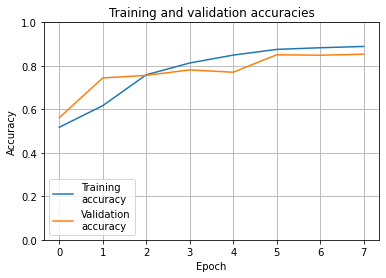

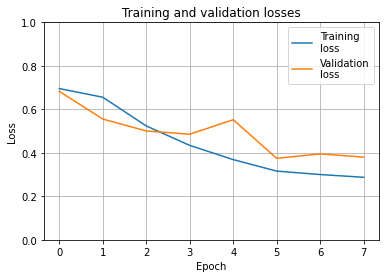

In [16]:
# visualize the performance of the model
plot_performance(hist_simple)

In [31]:
# test the model 
test_loss, test_acc = simple_RNN.evaluate(input_test, y_test, verbose=0)

# save performance
loss['simple_RNN'] = test_loss
acc['simple_RNN'] = test_acc

# print out the results
print("Test loss: {0:.{1}}".format(test_loss, 4))
print("Test accuracy: {0:.{1}}".format(test_acc, 4))

Test loss: 0.3872
Test accuracy: 0.8438


#### Conclusion
We achieve a test accuracy of about 84% which should be considered acceptable for this simple model architecture. The model's fit, on the other hand, is questionable since there are tendencies of overfitting after the fifth epoch. Therefore, we should not expect any extraordinary generalization capacity in this case.
___
 

#### Model 2: LSTM(32)
We build and train our second model, with only a small LSTM layer:

In [18]:
layer_2 = LSTM(
    units=32,
    dropout=0.25,
    kernel_regularizer=l2(1e-2),
    activity_regularizer=l2(1e-3),
    bias_regularizer=l2(1e-3)
)
lstm_32 = custom_model(layer_2, 'LSTM_32')

Model: "LSTM_32"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, None)]            0         
_________________________________________________________________
embedding_1 (Embedding)      (None, None, 32)          320000    
_________________________________________________________________
lstm (LSTM)                  (None, 32)                8320      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 328,353
Trainable params: 328,353
Non-trainable params: 0
_________________________________________________________________


In [19]:
hist_lstm_32 = compile_fit(lstm_32, EPOCHS, BATCH_SIZE, input_train, y_train)

Epoch 1/20
80/80 [==============================] - 8s 43ms/step - loss: 1.0706 - accuracy: 0.5558 - val_loss: 0.7163 - val_accuracy: 0.7994
Epoch 2/20
80/80 [==============================] - 3s 37ms/step - loss: 0.6512 - accuracy: 0.7886 - val_loss: 0.4668 - val_accuracy: 0.8504
Epoch 3/20
80/80 [==============================] - 3s 37ms/step - loss: 0.4330 - accuracy: 0.8579 - val_loss: 0.3932 - val_accuracy: 0.8714
Epoch 4/20
80/80 [==============================] - 3s 37ms/step - loss: 0.3585 - accuracy: 0.8885 - val_loss: 0.4361 - val_accuracy: 0.8390

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
Epoch 5/20
80/80 [==============================] - 3s 37ms/step - loss: 0.2842 - accuracy: 0.9151 - val_loss: 0.3421 - val_accuracy: 0.8894
Epoch 6/20
80/80 [==============================] - 3s 38ms/step - loss: 0.2603 - accuracy: 0.9265 - val_loss: 0.3390 - val_accuracy: 0.8902
Epoch 7/20
80/80 [==============================] - 3s 38ms/step - loss:

#### Perfomance of Model 2

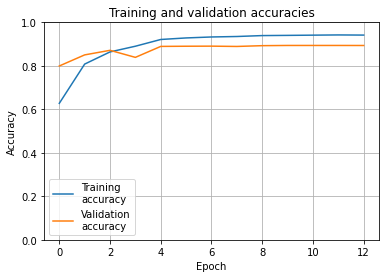

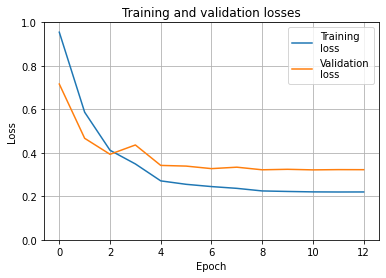

In [20]:
# visualize the performance of the model
plot_performance(hist_lstm_32)

In [33]:
# test the model 
test_loss, test_acc = lstm_32.evaluate(input_test, y_test, verbose=0)

# save performance
loss['lstm_32'] = test_loss
acc['lstm_32'] = test_acc

# print out the results
print("Test loss: {0:.{1}}".format(test_loss, 4))
print("Test accuracy: {0:.{1}}".format(test_acc, 4))

Test loss: 0.3365
Test accuracy: 0.8852


#### Conclusion
In this case, we obtain a test accuracy of about 89% and a bit lower test loss. This clearly shows that the more complex LSTM structure is required for this model. The fit is also better since we do not evidently overfit. However, the validation loss is consistenly larger than in the one in training. Possibly, this is an indication of an too simple model, i.e., the small architecture results in insufficient prediciton capacity. In order to improve a more complex model is necessary.
___

#### Model 3: LSTM(128)
We build and train our second model, with a larger LSTM layer:

In [22]:
layer_3 = LSTM(
    units=128,
    dropout=0.25,
    kernel_regularizer=l2(1e-2),
    activity_regularizer=l2(1e-3),
    bias_regularizer=l2(1e-3)
)
lstm_128 = custom_model(layer_3, 'LSTM_128')

Model: "LSTM_128"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, None)]            0         
_________________________________________________________________
embedding_2 (Embedding)      (None, None, 32)          320000    
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               82432     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 129       
Total params: 402,561
Trainable params: 402,561
Non-trainable params: 0
_________________________________________________________________


In [23]:
hist_lstm_128 = compile_fit(lstm_128, EPOCHS, BATCH_SIZE, input_train, y_train)

Epoch 1/20
80/80 [==============================] - 6s 51ms/step - loss: 1.1277 - accuracy: 0.5427 - val_loss: 0.7893 - val_accuracy: 0.6862
Epoch 2/20
80/80 [==============================] - 4s 47ms/step - loss: 0.7042 - accuracy: 0.7584 - val_loss: 0.6171 - val_accuracy: 0.7984
Epoch 3/20
80/80 [==============================] - 4s 48ms/step - loss: 0.5650 - accuracy: 0.8283 - val_loss: 0.5983 - val_accuracy: 0.7928
Epoch 4/20
80/80 [==============================] - 4s 47ms/step - loss: 0.5001 - accuracy: 0.8503 - val_loss: 0.4816 - val_accuracy: 0.8522
Epoch 5/20
80/80 [==============================] - 4s 46ms/step - loss: 0.4230 - accuracy: 0.8789 - val_loss: 0.4280 - val_accuracy: 0.8674
Epoch 6/20
80/80 [==============================] - 4s 47ms/step - loss: 0.3786 - accuracy: 0.8978 - val_loss: 0.5254 - val_accuracy: 0.8128

Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
Epoch 7/20
80/80 [==============================] - 4s 46ms/step - loss:

#### Performance of Model 3

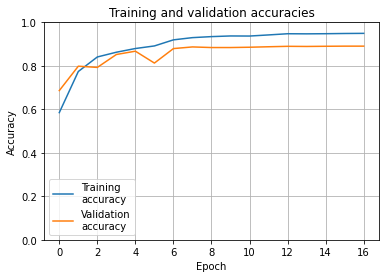

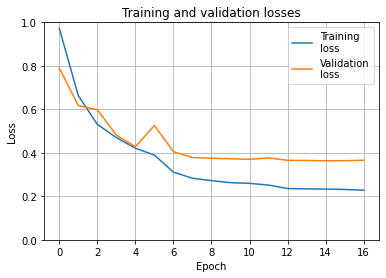

In [24]:
# visualize the performance of the model
plot_performance(hist_lstm_128)

In [34]:
# test the model 
test_loss, test_acc = lstm_128.evaluate(input_test, y_test, verbose=0)

# save performance
loss['lstm_128'] = test_loss
acc['lstm_128'] = test_acc

# print out the results
print("Test loss: {0:.{1}}".format(test_loss, 4))
print("Test accuracy: {0:.{1}}".format(test_acc, 4))

Test loss: 0.3819
Test accuracy: 0.8802


#### Conclusion
For this model we obtain similar results as the previous LSTM, with a test accuracy of approx. 88% and the same behavior in the validation loss curve. The conclusion we can jump to is, once again, that we are in need of a more complex model.
___

#### Model 4: Bidirectional(LSTM(32))
We build and train our second model, with a bidirectional RNN layer:

In [26]:
# we reuse 'layer_2', i.e. LSTM(32)
bi_lstm = custom_model(Bidirectional(layer_2), 'BiLSTM_32')

Model: "BiLSTM_32"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, None)]            0         
_________________________________________________________________
embedding_3 (Embedding)      (None, None, 32)          320000    
_________________________________________________________________
bidirectional (Bidirectional (None, 64)                16640     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 336,705
Trainable params: 336,705
Non-trainable params: 0
_________________________________________________________________


In [27]:
hist_bi_lstm = compile_fit(bi_lstm, EPOCHS, BATCH_SIZE, input_train, y_train)

Epoch 1/20
80/80 [==============================] - 8s 70ms/step - loss: 1.4294 - accuracy: 0.5705 - val_loss: 0.8688 - val_accuracy: 0.7138
Epoch 2/20
80/80 [==============================] - 5s 61ms/step - loss: 0.7334 - accuracy: 0.7774 - val_loss: 0.5107 - val_accuracy: 0.8482
Epoch 3/20
80/80 [==============================] - 5s 61ms/step - loss: 0.4751 - accuracy: 0.8592 - val_loss: 0.4265 - val_accuracy: 0.8666
Epoch 4/20
80/80 [==============================] - 5s 63ms/step - loss: 0.3819 - accuracy: 0.8853 - val_loss: 0.3932 - val_accuracy: 0.8720
Epoch 5/20
80/80 [==============================] - 5s 62ms/step - loss: 0.3288 - accuracy: 0.9065 - val_loss: 0.4415 - val_accuracy: 0.8620

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
Epoch 6/20
80/80 [==============================] - 5s 62ms/step - loss: 0.2644 - accuracy: 0.9333 - val_loss: 0.3526 - val_accuracy: 0.8904
Epoch 7/20
80/80 [==============================] - 5s 61ms/step - loss:

#### Performance of Model 4

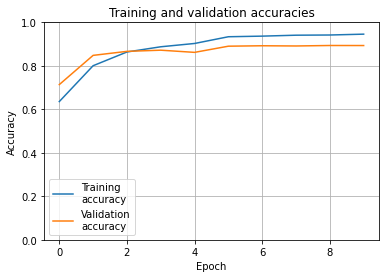

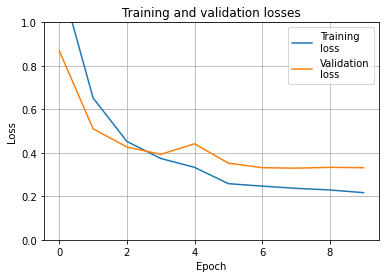

In [28]:
# visualize the performance of the model
plot_performance(hist_bi_lstm)

In [35]:
# test the model 
test_loss, test_acc = bi_lstm.evaluate(input_test, y_test, verbose=0)

# save performance
loss['bi_lstm'] = test_loss
acc['bi_lstm'] = test_acc

# print out the results
print("Test loss: {0:.{1}}".format(test_loss, 4))
print("Test accuracy: {0:.{1}}".format(test_acc, 4))

Test loss: 0.344
Test accuracy: 0.8838


#### Conclusion
Once again, there are no significant improvements and we remain with 88% test accuracy and an unsatisfactory validation loss curve...
___

### Summary of models
We check which model that performed best in testing:

In [36]:
print('Test performance:')
print('\nAccuracy')
for result in acc.items():
    print(result)

print('\nLoss')
for result in loss.items():
    print(result)

Test performance:

Accuracy
('simple_RNN', 0.8438000082969666)
('lstm_32', 0.8852400183677673)
('lstm_128', 0.8802000284194946)
('bi_lstm', 0.8837599754333496)

Loss
('simple_RNN', 0.3872324228286743)
('lstm_32', 0.3365170657634735)
('lstm_128', 0.3818831145763397)
('bi_lstm', 0.34399980306625366)



The above models could at best produce a test accuracy of around 88%, and I believe that we cannot expect that much more based on the simple model architectures used. However, these are not bad results and we have obtained some models with an acceptable fit. Lastly, the best model obtained is the "LSTM(32)" that had similar test accuracy compared to "LSTM(128)" and "Bidirectional(LSTM(32))", but had the lowest test loss! 

---



### Try test sequences on the best model
Now, we try classify the test sequences by our best model:

In [37]:
test_sentences = [
  "That movie was absolutely awful",
  "The acting was a bit lacking",
  "The film was creative and surprising",
  "Absolutely fantastic!",
  "This movie is not worth the money",
  "The only positive thing with this movie is the music"
]

# 1 is good, and 0 is bad
labels = [
          0, 
          0,
          1,
          1,
          0,
          0,
]

Create an index dictionary for the vocabulary in order to tokenize the test sentences:

In [62]:
# create a dictionary such that {word: index, ...}
# and add handler for "special words" in index 0-3
tokenizer = Tokenizer()
vocab_idx = imdb.get_word_index()
vocab = {k:(v + 3) for k, v in vocab_idx.items()}
vocab['<padding_word>'] = 0
vocab['<start_word>'] = 1 
vocab['<oov_word>'] = 2 # "out of vocabulary"
vocab['<unk_word>'] = 3 
tokenizer.word_index = vocab

#### Preprocess test sentences
In order to predict the sentences we have to convert the separate words in each sentence to corresponding index in the IMDB vocabulary, and then pad each sentence to 500x1 dimension. 

In [63]:
# preprocess test sentences by the IMDB tokenizer
samples = tokenizer.texts_to_sequences(test_sentences)
padded_samples = pad_sequences(samples, maxlen=maxlen)

# print out one sample
print(padded_samples[0])
padded_samples[0].shape

[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   

(500,)

The preproccessed sentences looks like desired. Now, let's predict:

In [64]:
# predict test sentences
preds = np.round(lstm_32.predict(padded_samples))

# print out predictions and corresponding label
for i in range(len(preds)):
    if preds[i] == labels[i]:
        print('Predicted %d: Correct!' %(preds[i]))
    else:
        print('Predicted %d: Incorrect...' %(preds[i]))

Predicted 0: Correct!
Predicted 1: Incorrect...
Predicted 1: Correct!
Predicted 1: Correct!
Predicted 1: Incorrect...
Predicted 0: Correct!


In [65]:
# print out unrounded predictions 
print(lstm_32.predict(padded_samples))

[[0.37818414]
 [0.5994509 ]
 [0.7125505 ]
 [0.6941553 ]
 [0.5616654 ]
 [0.39284953]]


### Discussion
The model got 4 out of 6 test sentences correct, which is a decent result considering how short the sentences are. However, if we study the unrounded predictions, we can see that our model is pessimistic for these sentences. The incorrect predictions is, expectedly, close to 0.5. On the other hand, the correct predictions are not that close to 0 or 1 for postive and negative reviews, respectively. This clearly shows that our model lacks classification power. 

Firstly, "The acting was a bit lacking" is difficult since it can likely be included in positive as well as negative reviews. It is not entirely negative and could therefore be a part of a longer positive review and thus, "confusing" our model. 
Secondly, "The movie is not worth the money" does not provide that much information since the sentence does not include any particular negative or positive attributes for a purely good (or bad) review. Thus, it is quite difficult to predict. 

Furthermore, these sentences/reviews are extremely short compared to average word length in IMDB, which is between 400 and 500 words, combined with our choiche of maximum word length of 500 in the data extraction. With that in mind, we cannot expect this particular model to be particulary good at these short "reviews" due to the sparsity in the encodings. If we combine this with the fact the we have pretty simple and small models, we should, unfortunately, not expect a performance much better than what we obtained in this laboration.